In [ ]:
from pathlib import Path
import os, sys
repo_path= Path.cwd().resolve()
while '.gitignore' not in os.listdir(repo_path): # while not in the root of the repo
    repo_path = repo_path.parent #go up one level
sys.path.insert(0,str(repo_path)) if str(repo_path) not in sys.path else None

#Libraries
import yaml
import math
import torch
import torch.nn.functional as F
from tqdm import tqdm
from torchvision.transforms import (
    Compose,
    Resize,
    CenterCrop,
    RandomHorizontalFlip,
    ToTensor,
    Normalize,
    InterpolationMode,
)
import wandb
import datasets, diffusers
from datasets import load_dataset
from diffusers import (
    UNet2DModel,
    DDPMScheduler,
    AutoencoderKL,
)    
from diffusers import DDPMPipeline
from diffusers.optimization import get_scheduler
from diffusers.utils import check_min_version
from diffusers.utils.import_utils import is_xformers_available
import logging
from accelerate.logging import get_logger
from accelerate import Accelerator

# extra
import pandas as pd
from PIL import Image
import csv
from packaging import version
import matplotlib.pyplot as plt

In [3]:
# create a dataset class for our breast images
class breast_dataset(torch.utils.data.Dataset):
    def __init__(self, csv_path: Path, images_dir: Path, transform=None):
        """_summary_

        Args:
            csv_path (Path): path to the csv file with the filenames
            images_dir (Path): path to the folder with the images
            transform (function, optional): transformation function. Usually pytorch.Transform. Defaults to None.
        """
        self.names = pd.read_csv(csv_path, header=None) # read csv file
        self.images_dir = images_dir # path to image folder
        self.transform = transform # transform to apply to images
    
    def __len__(self):
        """returns the length of the dataset

        Returns:
            int: length of the dataset
        """
        return len(self.names)
    
    def __getitem__(self, idx: int):
        """returns the image at index idx

        Args:
            idx (int): index in the csv file

        Returns:
            PIL.Image: PIL image
        """
        img_path = self.images_dir / self.names.iloc[idx, 0] # get image path
        image = Image.open(img_path) # open image
        # image = np.array(image, dtype=np.float32) # convert to numpy array
        if self.transform: # apply transform if it exists
            image = self.transform(image)
            
        return image
    
    def set_transform(self, transform):
        """set the transform to apply to the images

        Args:
            transform (function): transform to apply to the images
        """
        self.transform = transform

    def __repr__(self) -> str:
        return f"({len(self)} images)"

def load_breast_dataset(folder_dir:Path):
    # get directory name
    folder_name = folder_dir.name
    # check if the csv file with the filenames already exists
    csv_path = folder_dir.parent.parent / 'filenames' / f'{folder_name}.csv'
    if not csv_path.exists(): # if not, create it
        with open(csv_path, mode='w', newline='') as file:
            writer = csv.writer(file)
            for filename in os.listdir(folder_dir):
                if filename.endswith(".png"):
                    writer.writerow([filename])
    # now we can create the dataset
    dataset = breast_dataset(csv_path, images_dir= folder_dir)
    
    return dataset    


In [4]:
# GPU and config
selected_gpu = 0 #select the GPU to use
device = torch.device("cuda:" + str(selected_gpu) if torch.cuda.is_available() else "cpu")
print(f'The device is: {device}\n')
# load the config file
config_path = repo_path / 'experiments/unconditional_vae/config.yaml'
with open(config_path) as file: # expects the config file to be in the same directory
        config = yaml.load(file, Loader=yaml.FullLoader)

### 1. Dataset loading and preprocessing
# Dataset loading
data_dir = repo_path / config['processing']['dataset']
dataset = load_breast_dataset(data_dir)
# Define data augmentations
class ToFloat32Tensor(object):
    """
    Converts a PIL Image to a PyTorch tensor with dtype float32, and normalises it.
    """
    def __call__(self, image):
        # Convert PIL Image to PyTorch tensor with dtype float32
        tensor = ToTensor()(image).float()/config['processing']['normalisation_value']
        return tensor

preprocess = Compose(
    [
        Resize(config['processing']['resolution'], interpolation= InterpolationMode.BILINEAR), #getattr(InterpolationMode, config['processing']['interpolation'])),  # Smaller edge is resized to 256 preserving aspect ratio
        CenterCrop(config['processing']['resolution']),  # Center crop to the desired squared resolution
        #RandomHorizontalFlip(),  # Horizontal flip may not be a good idea if we want generation only one laterality
        ToFloat32Tensor(),  # Convert to tensor (0, 1)
        Normalize(mean=[0.5], std=[0.5]),  # Map to (-1, 1) as a way to make data more similar to a Gaussian distribution
    ]
)
#set the transform function to the dataset
dataset.set_transform(preprocess)
# Create the dataloader
# Create the dataloader
train_dataloader = torch.utils.data.DataLoader(
    dataset, batch_size=1, num_workers= config['processing']['num_workers'], shuffle=False # need order
)

vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae")
vae.requires_grad_(False)
# send vae to accelerator
vae.to(device);

The device is: cuda:0



In [5]:
# get next batch
batch = next(iter(train_dataloader))
batch = batch.to(device)

# # read csv file with the filenames
# csv_path = repo_path / 'data/filenames/breast10p.csv'
# names = pd.read_csv(csv_path, header=None)
# name = names.iloc[i].item()

# extract vae version
    

In [6]:
# original batch expansion
batch_exp = batch.expand(-1, 3, -1, -1) # expand the batch to have three channels
# add extra two channels with zeros
batch_2 = torch.cat((batch, torch.zeros(batch.shape[0], 2, batch.shape[2], batch.shape[3]).to(device)), dim=1)

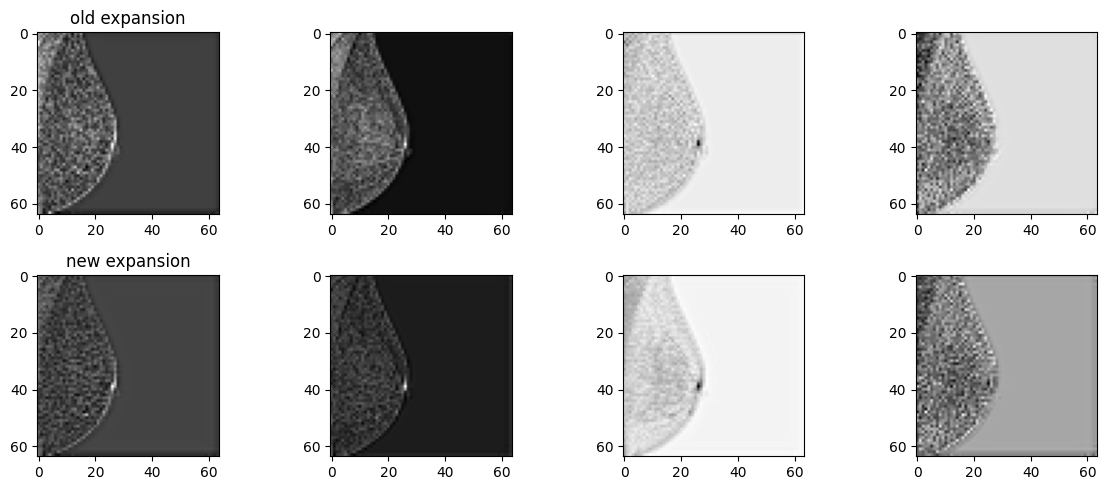

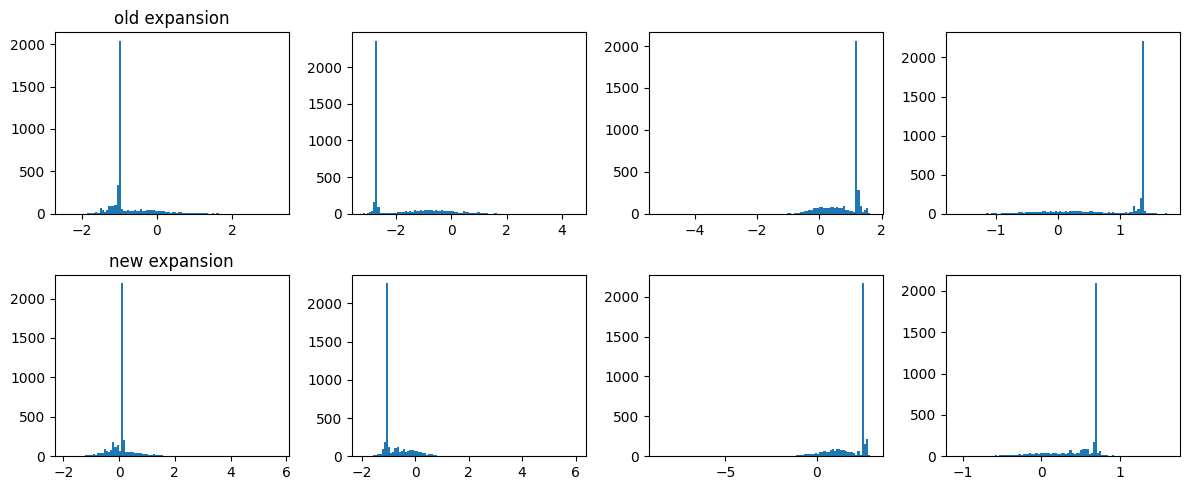

In [7]:
# old expansion
latents_exp = vae.encode(batch_exp).latent_dist.sample() # sample from the latent distribution
latents_exp = latents_exp * vae.config.scaling_factor # scale the latents so they are around -1 and 1 (but not exactly)

# new expansion
latents_2 = vae.encode(batch_2).latent_dist.sample() # sample from the latent distribution
latents_2 = latents_2 * vae.config.scaling_factor # scale the latents so they are around -1 and 1 (but not exactly)



# show latents
fig, axs = plt.subplots(2, 4, figsize=(12, 5))
for i in range(4):
    axs[0,i].imshow(latents_exp[0, i].detach().cpu().numpy(), cmap='gray')
    axs[1,i].imshow(latents_2[0, i].detach().cpu().numpy(), cmap='gray')
axs[0,0].set_title('old expansion')
axs[1,0].set_title('new expansion')
fig.tight_layout()
# show histogram of the latents
fig, axs = plt.subplots(2, 4, figsize=(12, 5))
for i in range(4):
    axs[0,i].hist(latents_exp[0, i].detach().cpu().numpy().flatten(), bins=100)
    axs[1,i].hist(latents_2[0, i].detach().cpu().numpy().flatten(), bins=100)
axs[0,0].set_title('old expansion')
axs[1,0].set_title('new expansion')
# give extra space between subplots
fig.tight_layout()


# # save latents as torch tensor withoput gradients
# latents = latents.detach()
# torch.save(latents, repo_path / 'data/images/breast10p_latents'/f'{Path(name).stem}.pt')

## Reconstruction

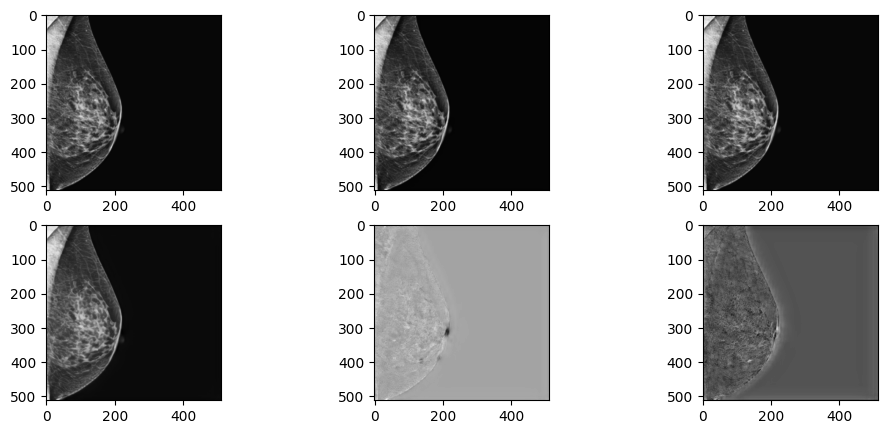

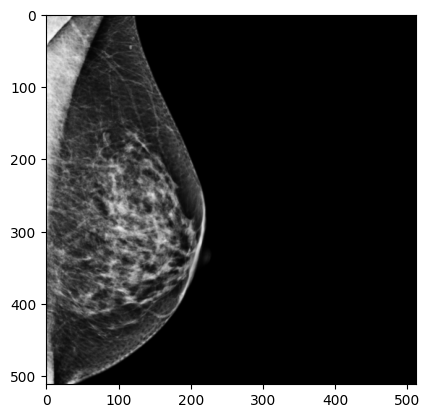

In [16]:
# old expansion
decompress_exp = latents_exp/vae.config.scaling_factor
decompress_exp = vae.decode(decompress_exp).sample
# new expansion
decompress_2 = latents_2/vae.config.scaling_factor
decompress_2 = vae.decode(decompress_2).sample

# show decompressed images
fig, axs = plt.subplots(2, 3, figsize=(12, 5))
for i in range(3):
    axs[0,i].imshow(decompress_exp[0, i].detach().cpu().numpy(), cmap='gray')
    axs[1,i].imshow(decompress_2[0, i].detach().cpu().numpy(), cmap='gray')
plt.figure()
plt.imshow(batch[0,0].detach().cpu().numpy(), cmap='gray')

# save decompressed images individually
for i in range(3):
    plt.imsave(f'decompressed_{i}.png', decompress_exp[0, i].detach().cpu().numpy(), cmap='gray')
    plt.imsave(f'decompressed_2_{i}.png', decompress_2[0, i].detach().cpu().numpy(), cmap='gray')

Text(0.5, 1.0, 'new expansion')

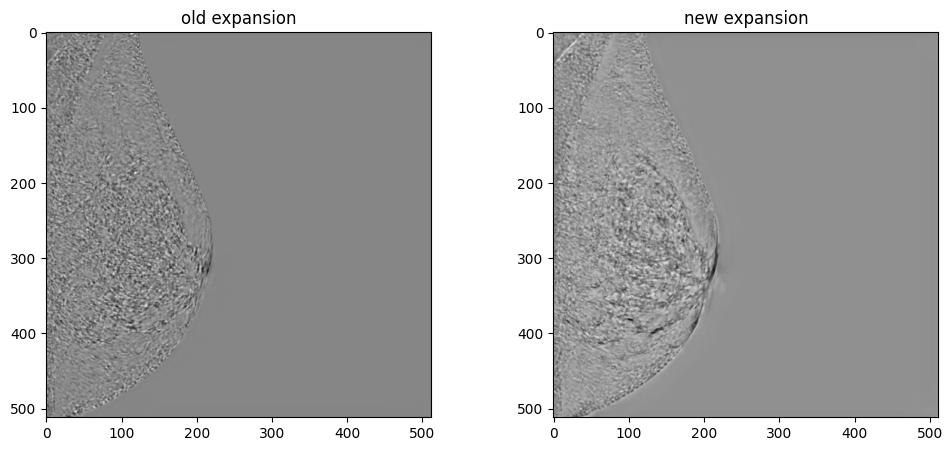

In [15]:
# check substractions between the two decompressed images with the original image
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
axs[0].imshow((decompress_exp[0, 0].detach().cpu().numpy() - batch[0,0].detach().cpu().numpy()), cmap='gray')
axs[1].imshow((decompress_2[0, 0].detach().cpu().numpy() - batch[0,0].detach().cpu().numpy()), cmap='gray')
# titles
axs[0].set_title('old expansion')
axs[1].set_title('new expansion')
